In [1]:
import sys
sys.path.append("../..") 

In [2]:
import glob,os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import numpy as np

In [3]:
# args
RES_PATH = "../../experiments/simulations/data_size/"

In [4]:
def get_metrics_from_folder(path):
    df_tests = []
    for folder in os.listdir(path):
        if folder.startswith('.') == False:
            pathm = os.path.join(path, folder, "metrics.csv")
            pathc = os.path.join(path, folder, "checkpoints/")
            paths = os.path.join(path, folder, "settings.csv")
            # model name:
            for _, _, files in os.walk(pathc):
                file = [f for f in files if f.endswith('.ckpt')][0]
                chk_path = os.path.join(pathc,file)
            checkpoint = torch.load(chk_path)
            model_name = checkpoint["hyper_parameters"]['net']
            hidden_dim_t = checkpoint["hyper_parameters"]['hidden_dims']
            # sim settings
            settings = pd.read_csv(paths)
            # model results:
            df = pd.read_csv(pathm)
            df_test = df.loc[:,df.columns.str.startswith('test') | df.columns.str.startswith('int')]
            df_test = df_test.dropna()
            df_test.loc[:,'model'] = model_name
            df_test.loc[:,'N'] = settings.N.item()
            df_tests.append(df_test)
        df_test = pd.concat(df_tests, axis=0)
    return df_test

In [5]:
df_test = get_metrics_from_folder(RES_PATH)

In [6]:
df_test

,test_loss,test_loss_pred,test_loss_update,test_rmse,test_var_pit,test_crps,test_ignorance,test_int_score,int_coverage,int_med_width,int_av_width,model,N
1987,-2.922253,-2.761095,-3.072708,2.977862,0.077956,0.011043,2.599937,0.093770,0.964969,9.803833,11.287262,IMODE,10000
1320,-2.754298,-2.606161,-2.858523,3.274684,0.062031,0.012487,2.458024,0.103389,0.965718,10.703362,12.717064,IMODE,20000
5500,-2.984900,-2.805718,-3.284266,2.894126,0.082774,0.010722,2.626537,0.091676,0.948878,8.409569,10.394939,ODEGRUBayes,20000
2800,-2.952748,-2.796400,-3.039853,2.875421,0.084171,0.010613,2.640053,0.090795,0.948121,8.820450,10.178656,ctRNNModel,10000
1460,-2.521663,-2.394387,-2.533586,3.790975,0.076763,0.014557,2.267112,0.132512,0.957598,13.063347,14.698152,neuralJumpModel,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5500,-3.010785,-2.836124,-3.252003,2.828288,0.084997,0.010434,2.661463,0.089415,0.946963,8.539818,9.916445,ctLSTMModel,20000
1460,-2.843830,-2.691843,-2.941784,3.061358,0.077782,0.011467,2.539856,0.101526,0.955440,9.560715,11.683377,IMODE,5000
380,-2.707582,-2.607714,-2.352477,3.136052,0.082412,0.011786,2.507845,0.106299,0.945722,8.868065,11.496680,ODEGRUBayes,1000
1460,-2.814632,-2.685612,-2.697515,3.077287,0.086060,0.011412,2.556592,0.100386,0.938237,8.773331,10.516529,ODEGRUBayes,5000


In [7]:
d = {'neuralJumpModel':'NJ-ODE',
     'ctRNNModel':'ODE-SRN',
     'ctGRUModel':'ODE-GRU',
     'ctLSTMModel':'ODE-LSTM',
     'ODEGRUBayes':'ODE-GRU-Bayes (LL)',
     'resNeuralJumpModel':'rNJ-ODE',
     'IMODE':'IMODE'}

In [8]:
df_test['model_name'] = [d[m] for m in df_test.model]

In [9]:
df_test["N1"] = df_test.N / 1000

In [10]:
df_test.test_ignorance = -df_test.test_ignorance

In [11]:
headline_metrics = ['test_rmse','test_crps','test_int_score','int_coverage']
metric_cols = ['test_loss_update','test_rmse','test_var_pit','test_crps','test_ignorance','test_int_score',
               'int_coverage','int_med_width','int_av_width']

In [12]:
df_test.loc[:,headline_metrics + ["model_name","N"]].groupby(["model_name","N"]).agg(["mean","std"])

test_rmse           test_crps            \
                              mean       std      mean       std   
model_name         N                                               
IMODE              1000   4.008852  0.698268  0.014698  0.002701   
                   5000   3.149156  0.185915  0.011642  0.000446   
                   10000  3.067710  0.095890  0.011315  0.000237   
                   20000  3.134112  0.130879  0.011835  0.000608   
NJ-ODE             1000   4.339843  0.205982  0.017098  0.001066   
                   5000   3.910857  0.156865  0.015223  0.000735   
                   10000  3.802604  0.022169  0.014719  0.000212   
                   20000  3.815663  0.066064  0.014596  0.000184   
ODE-GRU            1000   3.092964  0.073874  0.011832  0.000095   
                   5000   2.992730  0.040978  0.011127  0.000206   
                   10000  2.941234  0.074462  0.010911  0.000275   
                   20000  2.878555  0.042230  0.010633  0.000205   
ODE-GRU-Bayes (LL) 1000   3.169464  0.143745  0.011830  0.000254   
                   5000   3.007572  0.060389  0.011159  0.000229   
                   10000  2.943874  0.047271  0.010908  0.000215   
                   20000  2.872590  0.027680  0.010613  0.000112   
ODE-LSTM           1000   3.030639  0.116384  0.011507  0.000179   
                   5000   2.986683  0.048305  0.011183  0.000237   
                   10000  2.959272  0.125020  0.011039  0.000580   
                   20000  2.853345  0.032140  0.010557  0.000176   
ODE-SRN            1000   3.098438  0.128026  0.011772  0.000287   
                   5000   3.050478  0.061810  0.011240  0.000152   
                   10000  2.977351  0.127532  0.011081  0.000621   
                   20000  2.875722  0.006828  0.010589  0.000038   
rNJ-ODE            1000   3.478527  0.155556  0.013371  0.000779   
                   5000   3.130459  0.093128  0.011731  0.000350   
                   10000  2.992452  0.008719  0.011171  0.000018   
                   20000  2.930310  0.011928  0.010897  0.000046   

                         test_int_score           int_coverage            
                                   mean       std         mean       std  
model_name         N                                                      
IMODE              1000        0.131182  0.016403     0.965968  0.006568  
                   5000        0.101249  0.002972     0.956058  0.002722  
                   10000       0.097234  0.003077     0.955597  0.008604  
                   20000       0.102023  0.003751     0.951684  0.016320  
NJ-ODE             1000        0.167533  0.012462     0.961027  0.004486  
                   5000        0.140700  0.007675     0.948742  0.010796  
                   10000       0.136514  0.004900     0.945930  0.003905  
                   20000       0.134167  0.002434     0.952549  0.004553  
ODE-GRU            1000        0.103677  0.003816     0.947856  0.005359  
                   5000        0.097688  0.001211     0.941705  0.006256  
                   10000       0.093851  0.002177     0.947709  0.012318  
                   20000       0.090630  0.001284     0.953969  0.001816  
ODE-GRU-Bayes (LL) 1000        0.105988  0.004044     0.946195  0.002372  
                   5000        0.097952  0.002472     0.940701  0.009957  
                   10000       0.093819  0.002914     0.951347  0.018129  
                   20000       0.091088  0.000626     0.954776  0.008787  
ODE-LSTM           1000        0.102113  0.002653     0.947876  0.006310  
                   5000        0.097196  0.004129     0.944253  0.006175  
                   10000       0.094433  0.005253     0.945978  0.022856  
                   20000       0.090357  0.001181     0.951686  0.004755  
ODE-SRN            1000        0.105652  0.003464     0.945553  0.002229  
                   5000        0.098353  0.002531     0.941110  0.004521  
                   10000       0.094776  

In [13]:
df_test.loc[:,metric_cols + ["model_name","N"]].groupby(["model_name","N"]).agg(["mean","std"])

test_loss_update           test_rmse            \
                                     mean       std      mean       std   
model_name         N                                                      
IMODE              1000         -2.395130  0.121408  4.008852  0.698268   
                   5000         -2.929489  0.021614  3.149156  0.185915   
                   10000        -3.038340  0.030001  3.067710  0.095890   
                   20000        -2.875114  0.037038  3.134112  0.130879   
NJ-ODE             1000         -2.015184  0.105087  4.339843  0.205982   
                   5000         -2.420157  0.102449  3.910857  0.156865   
                   10000        -2.555695  0.185246  3.802604  0.022169   
                   20000        -2.772196  0.055261  3.815663  0.066064   
ODE-GRU            1000         -2.404577  0.031931  3.092964  0.073874   
                   5000         -3.022939  0.203036  2.992730  0.040978   
                   10000        -3.236498  0.020124  2.941234  0.074462   
                   20000        -3.276548  0.041190  2.878555  0.042230   
ODE-GRU-Bayes (LL) 1000         -2.373957  0.023377  3.169464  0.143745   
                   5000         -2.899605  0.293840  3.007572  0.060389   
                   10000        -3.200684  0.083093  2.943874  0.047271   
                   20000        -3.287221  0.004245  2.872590  0.027680   
ODE-LSTM           1000         -2.477523  0.013652  3.030639  0.116384   
                   5000         -2.888053  0.363425  2.986683  0.048305   
                   10000        -3.209370  0.065626  2.959272  0.125020   
                   20000        -3.209187  0.138394  2.853345  0.032140   
ODE-SRN            1000         -2.506251  0.020618  3.098438  0.128026   
                   5000         -2.919854  0.171289  3.050478  0.061810   
                   10000        -3.128352  0.077545  2.977351  0.127532   
                   20000        -3.223733  0.064698  2.875722  0.006828   
rNJ-ODE            1000         -2.397155  0.074767  3.478527  0.155556   
                   5000         -2.680540  0.028704  3.130459  0.093128   
                   10000        -2.771544  0.034970  2.992452  0.008719   
                   20000        -2.871597  0.030230  2.930310  0.011928   

                         test_var_pit           test_crps            \
                                 mean       std      mean       std   
model_name         N                                                  
IMODE              1000      0.069324  0.005811  0.014698  0.002701   
                   5000      0.079345  0.001580  0.011642  0.000446   
                   10000     0.077680  0.000275  0.011315  0.000237   
                   20000     0.076235  0.012454  0.011835  0.000608   
NJ-ODE             1000      0.065293  0.000332  0.017098  0.001066   
                   5000      0.077834  0.001163  0.015223  0.000735   
                   10000     0.078307  0.001740  0.014719  0.000212   
                   20000     0.076915  0.002081  0.014596  0.000184   
ODE-GRU            1000      0.082423  0.001898  0.011832  0.000095   
                   5000      0.084989  0.001038  0.011127  0.000206   
                   10000     0.079763  0.001147  0.010911  0.000275   
                   20000     0.079991  0.002644  0.010633  0.000205   
ODE-GRU-Bayes (LL) 1000      0.080824  0.002058  0.011830  0.000254   
                   5000      0.084297  0.003267  0.011159  0.000229   
                   10000     0.079012  0.005246  0.010908  0.000215   
                   20000     0.080804  0.005025  0.010613  0.000112   
ODE-LSTM           1000      0.082879  0.002994  0.011507  0.000179   
                   5000      0.083392  0.000803  0.011183  0.000237   
                   10000     0.079807  0.002600  0.011039  0.000580   
                   20000     0.082603  0.002710  0.010557  0.000176   
ODE-SRN            1000      0.082349  0.002081  0.011772  0.00028

In [14]:
hue_order = ['NJ-ODE', 'rNJ-ODE','ODE-SRN','ODE-GRU','ODE-GRU-Bayes (LL)','ODE-GRU-Bayes (KL)', 'ODE-LSTM','IMODE']

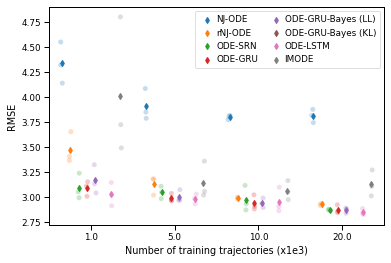

In [15]:
sns.set_context("paper")
f, ax = plt.subplots()
sns.stripplot(x="N1", y="test_rmse", hue="model_name",hue_order=hue_order,data=df_test,dodge=True,alpha=.25,zorder=1)
sns.pointplot(x="N1", y="test_rmse", hue="model_name",hue_order=hue_order,data=df_test,join=False, dodge=.8 - .8 / 7,
              markers="d", scale=.75, ci=None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[8:], labels[8:], title="", handletextpad=0, columnspacing=1,
          loc="upper right", ncol=2, frameon=True)
ax.set_xlabel('Number of training trajectories (x1e3)')
ax.set_ylabel('RMSE')
f.savefig('../../results/sim_data_size_rmse1.png', dpi=300)
plt.show()

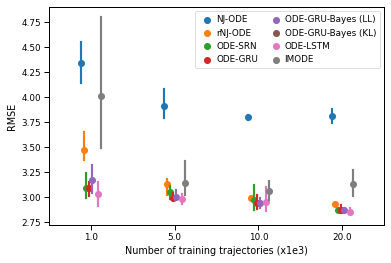

In [16]:
sns.set_context("paper")
f, ax = plt.subplots()
sns.pointplot(x="N1", y="test_rmse", hue="model_name",hue_order=hue_order,data=df_test,dodge=0.25,alpha=.25,join=False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="", handletextpad=0, columnspacing=1,
          loc="upper right", ncol=2, frameon=True)
ax.set_xlabel('Number of training trajectories (x1e3)')
ax.set_ylabel('RMSE')
f.savefig('../../results/sim_data_size_rmse2.png', dpi=300)
plt.show()

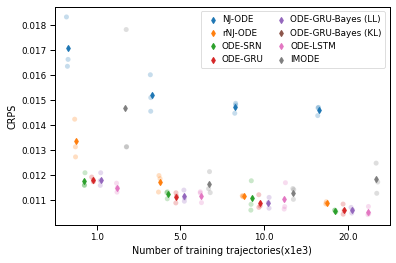

In [17]:
sns.set_context("paper")
f, ax = plt.subplots()
sns.stripplot(x="N1", y="test_crps", hue="model_name",hue_order=hue_order,data=df_test,dodge=True,alpha=.25,zorder=1)
sns.pointplot(x="N1", y="test_crps", hue="model_name",hue_order=hue_order,data=df_test,join=False, dodge=.8 - .8 / 7,
              markers="d", scale=.75, ci=None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[8:], labels[8:], title="", handletextpad=0, columnspacing=1,
          loc="upper right", ncol=2, frameon=True)
ax.set_xlabel('Number of training trajectories(x1e3)')
ax.set_ylabel('CRPS')
f.savefig('../../results/sim_data_size_crps1.png', dpi=300)
plt.show()

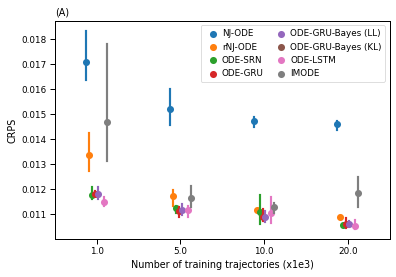

In [18]:
sns.set_context("paper")
f, ax = plt.subplots()
sns.pointplot(x="N1", y="test_crps", hue="model_name",hue_order=hue_order,data=df_test,dodge=0.25,alpha=.25,join=False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="", handletextpad=0, columnspacing=1,
          loc="upper right", ncol=2, frameon=True)
ax.set_xlabel('Number of training trajectories (x1e3)')
ax.set_ylabel('CRPS')
ax.set_title('(A)',loc='left')
f.savefig('../../results/sim_data_size_crps2.png', dpi=300)
plt.show()

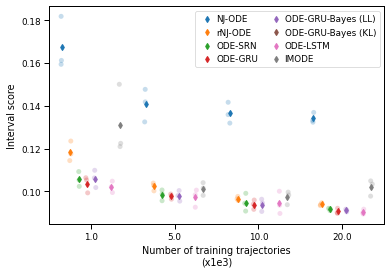

In [19]:
sns.set_context("paper")
f, ax = plt.subplots()
sns.stripplot(x="N1", y="test_int_score", hue="model_name",hue_order=hue_order,data=df_test,dodge=True,alpha=.25,zorder=1)
sns.pointplot(x="N1", y="test_int_score", hue="model_name",hue_order=hue_order,data=df_test,join=False, dodge=.8 - .8 / 7,
              markers="d", scale=.75, ci=None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[8:], labels[8:], title="", handletextpad=0, columnspacing=1,
          loc="upper right", ncol=2, frameon=True)
ax.set_xlabel('Number of training trajectories\n(x1e3)')
ax.set_ylabel('Interval score')
f.savefig('../../results/sim_data_size_int_score1.png', dpi=300)
plt.show()

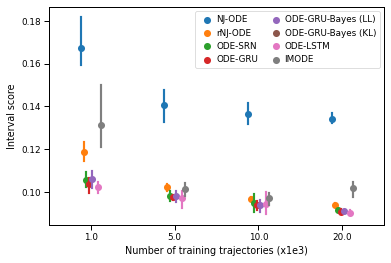

In [20]:
sns.set_context("paper")
f, ax = plt.subplots()
sns.pointplot(x="N1", y="test_int_score", hue="model_name",hue_order=hue_order,data=df_test,dodge=0.25,alpha=.25,join=False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="", handletextpad=0, columnspacing=1,
          loc="upper right", ncol=2, frameon=True)
ax.set_xlabel('Number of training trajectories (x1e3)')
ax.set_ylabel('Interval score')
f.savefig('../../results/sim_data_size_int_score2.png', dpi=300)
plt.show()

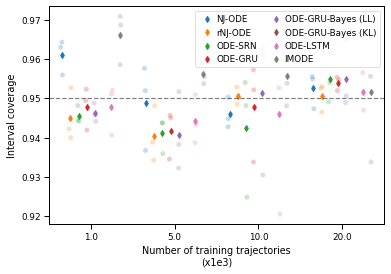

In [21]:
sns.set_context("paper")
f, ax = plt.subplots()
ax.axhline(0.95,ls='--',color="black",alpha=0.5)
sns.stripplot(x="N1", y="int_coverage", hue="model_name",hue_order=hue_order,data=df_test,dodge=True,alpha=.25,zorder=1)
sns.pointplot(x="N1", y="int_coverage", hue="model_name",hue_order=hue_order,data=df_test,join=False, dodge=.8 - .8 / 7,
              markers="d", scale=.75, ci=None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[8:], labels[8:], title="", handletextpad=0, columnspacing=1,
          loc="upper right", ncol=2, frameon=True)
ax.set_xlabel('Number of training trajectories\n(x1e3)')
ax.set_ylabel('Interval coverage')
f.savefig('../../results/sim_data_size_int_coverage1.png', dpi=300)
plt.show()

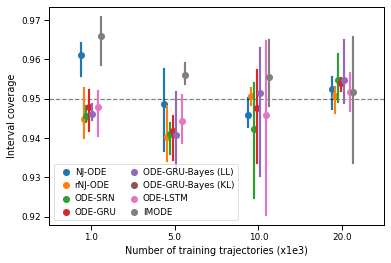

In [22]:
sns.set_context("paper")
f, ax = plt.subplots()
ax.axhline(0.95,ls='--',color="black",alpha=0.5)
sns.pointplot(x="N1", y="int_coverage", hue="model_name",hue_order=hue_order,data=df_test,dodge=0.25,alpha=.25,join=False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="", handletextpad=0, columnspacing=1,
          loc="lower left", ncol=2, frameon=True)
ax.set_xlabel('Number of training trajectories (x1e3)')
ax.set_ylabel('Interval coverage')
f.savefig('../../results/sim_data_size_int_coverage2.png', dpi=300)
plt.show()

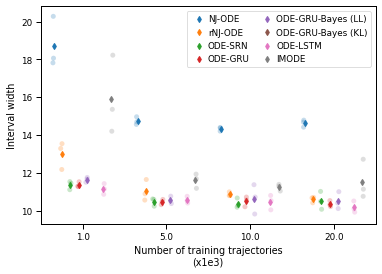

In [23]:
sns.set_context("paper")
f, ax = plt.subplots()
sns.stripplot(x="N1", y="int_av_width", hue="model_name",hue_order=hue_order,data=df_test,dodge=True,alpha=.25,zorder=1)
sns.pointplot(x="N1", y="int_av_width", hue="model_name",hue_order=hue_order,data=df_test,join=False, dodge=.8 - .8 / 7,
              markers="d", scale=.75, ci=None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[8:], labels[8:], title="", handletextpad=0, columnspacing=1,
          loc="upper right", ncol=2, frameon=True)
ax.set_xlabel('Number of training trajectories\n(x1e3)')
ax.set_ylabel('Interval width')
f.savefig('../../results/sim_data_size_int_av_width1.png', dpi=300)
plt.show()

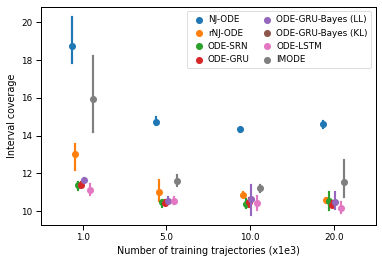

In [24]:
sns.set_context("paper")
f, ax = plt.subplots()
sns.pointplot(x="N1", y="int_av_width", hue="model_name",hue_order=hue_order,data=df_test,dodge=0.25,alpha=.25,join=False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="", handletextpad=0, columnspacing=1,
          loc="upper right", ncol=2, frameon=True)
ax.set_xlabel('Number of training trajectories (x1e3)')
ax.set_ylabel('Interval coverage')
f.savefig('../../results/sim_data_size_int_coverage2.png', dpi=300)
plt.show()

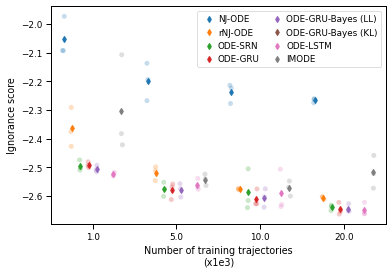

In [25]:
sns.set_context("paper")
f, ax = plt.subplots()
sns.stripplot(x="N1", y="test_ignorance", hue="model_name",hue_order=hue_order,data=df_test,dodge=True,alpha=.25,zorder=1)
sns.pointplot(x="N1", y="test_ignorance", hue="model_name",hue_order=hue_order,data=df_test,join=False, dodge=.8 - .8 / 7,
              markers="d", scale=.75, ci=None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[8:], labels[8:], title="", handletextpad=0, columnspacing=1,
          loc="upper right", ncol=2, frameon=True)
ax.set_xlabel('Number of training trajectories\n(x1e3)')
ax.set_ylabel('Ignorance score')
f.savefig('../../results/sim_data_size_ignorance1.png', dpi=300)
plt.show()

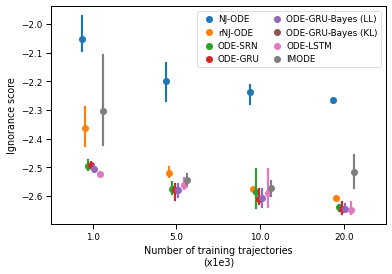

In [26]:
sns.set_context("paper")
f, ax = plt.subplots()
sns.pointplot(x="N1", y="test_ignorance", hue="model_name",hue_order=hue_order,data=df_test,dodge=0.25,alpha=.25,join=False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="", handletextpad=0, columnspacing=1,
          loc="upper right", ncol=2, frameon=True)
ax.set_xlabel('Number of training trajectories\n(x1e3)')
ax.set_ylabel('Ignorance score')
f.savefig('../../results/sim_data_size_ignorance2.png', dpi=300)
plt.show()

In [27]:
def get_val_from_folder(path):
    df_tests = []
    for folder in os.listdir(path):
        if folder.startswith('.') == False:
            pathm = os.path.join(path, folder, "metrics.csv")
            pathc = os.path.join(path, folder, "checkpoints/")
            paths = os.path.join(path, folder, "settings.csv")
            # model name:
            for _, _, files in os.walk(pathc):
                file = [f for f in files if f.endswith('.ckpt')][0]
                chk_path = os.path.join(pathc,file)
            checkpoint = torch.load(chk_path)
            model_name = checkpoint["hyper_parameters"]['net']
            hidden_dim_t = checkpoint["hyper_parameters"]['hidden_dims']
            # sim settings
            settings = pd.read_csv(paths)
            # model results:
            df = pd.read_csv(pathm)
            df_test = df.loc[:,df.columns.str.startswith('val') | df.columns.str.startswith('epoch')]
            df_test = df_test.dropna()
            df_test.loc[:,'version'] = folder
            df_test.loc[:,'model'] = model_name
            df_test.loc[:,'N'] = settings.N.item()
            df_tests.append(df_test)
        df_test = pd.concat(df_tests, axis=0)
    return df_test

In [28]:
df_val = get_val_from_folder(RES_PATH)

In [29]:
df_val

,epoch,val_loss,val_loss_pred,val_loss_update,val_rmse,version,model,N
26,0.0,-11264.404297,-10381.431641,-8829.714844,6.553798,version_55,IMODE,10000
55,1.0,-14304.291992,-13008.359375,-12959.335938,5.036906,version_55,IMODE,10000
82,2.0,-14473.512695,-13096.763672,-13767.475586,4.985198,version_55,IMODE,10000
111,3.0,-14808.012695,-13400.531250,-14074.816406,4.921812,version_55,IMODE,10000
138,4.0,-16104.512695,-14656.935547,-14475.750977,3.911541,version_55,IMODE,10000
...,...,...,...,...,...,...,...,...
2687,95.0,-18778.480469,-16629.666016,-21488.130859,2.862949,version_56,ctRNNModel,10000
2714,96.0,-18782.029297,-16631.509766,-21505.183594,2.862372,version_56,ctRNNModel,10000
2743,97.0,-18785.533203,-16633.337891,-21521.947266,2.861799,version_56,ctRNNModel,10000
2770,98.0,-18788.992188,-16635.150391,-21538.429688,2.861229,version_56,ctRNNModel,10000


In [30]:
df_val['model_name'] = [d[m] for m in df_val.model]

In [31]:
model_N = df_val.loc[:,['model','N']].drop_duplicates().copy()
model_N = model_N.sort_values(['model','N'])
model_N.reset_index(inplace=True,drop=True)
model_N

,model,N
0,IMODE,1000
1,IMODE,5000
2,IMODE,10000
3,IMODE,20000
4,ODEGRUBayes,1000
5,ODEGRUBayes,5000
6,ODEGRUBayes,10000
7,ODEGRUBayes,20000
8,ctGRUModel,1000
9,ctGRUModel,5000


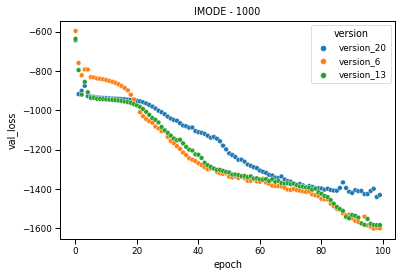

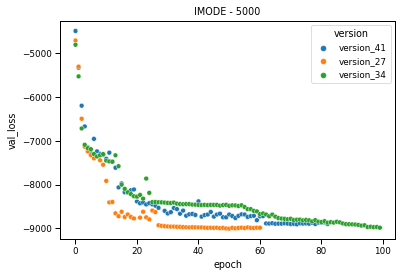

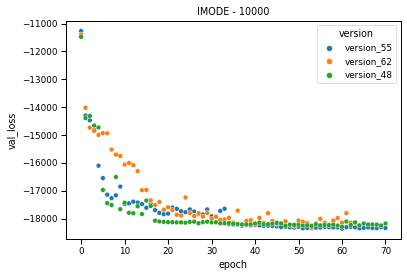

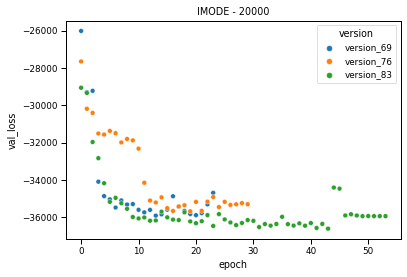

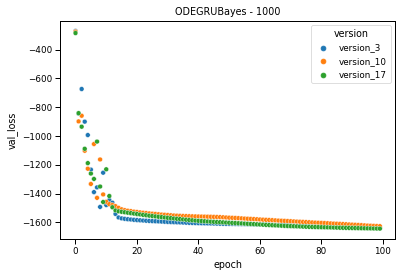

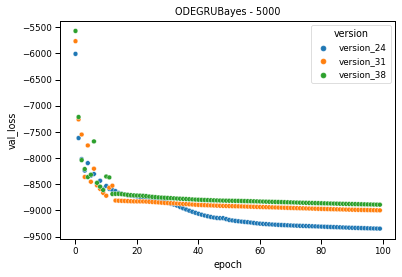

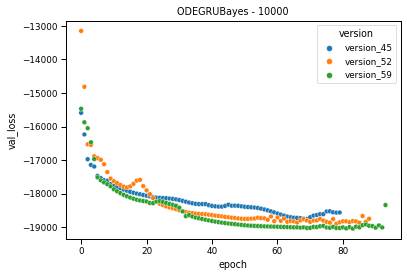

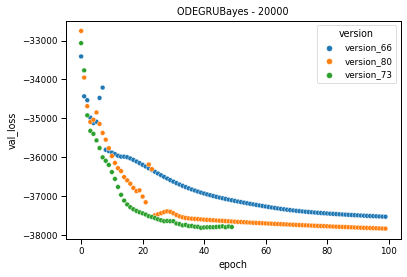

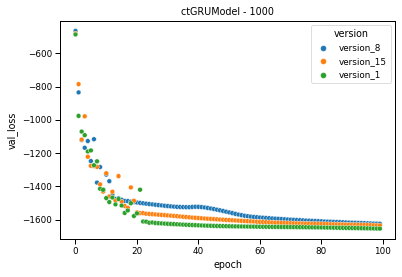

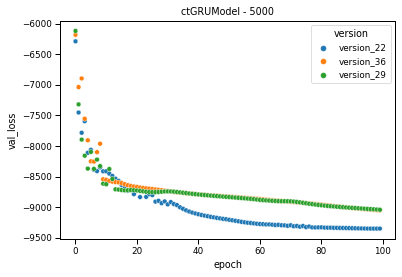

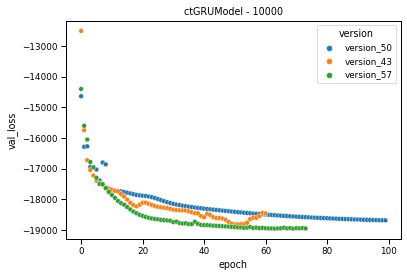

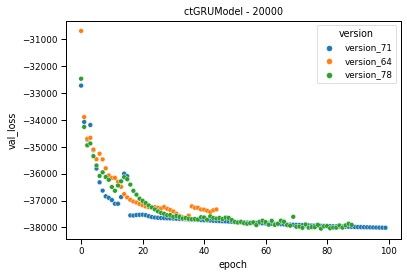

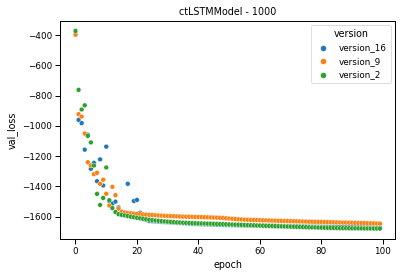

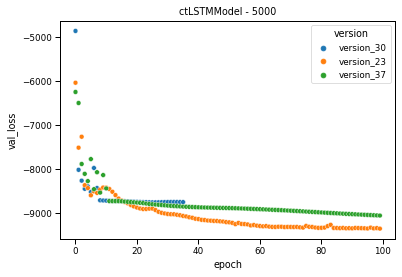

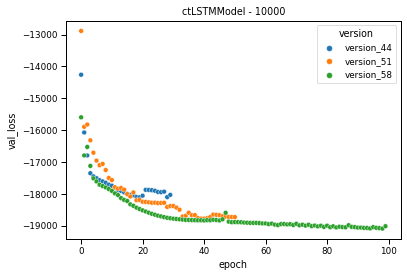

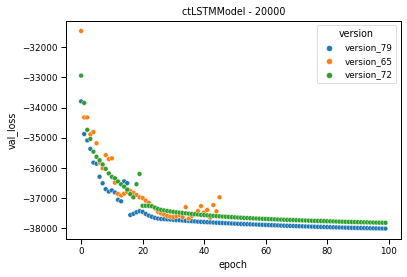

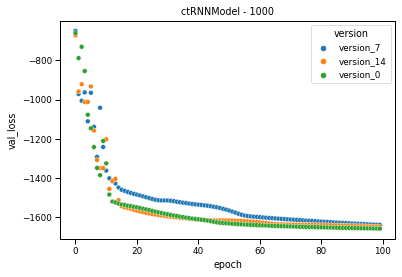

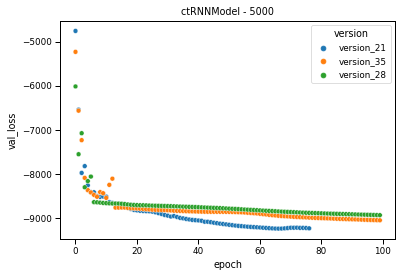

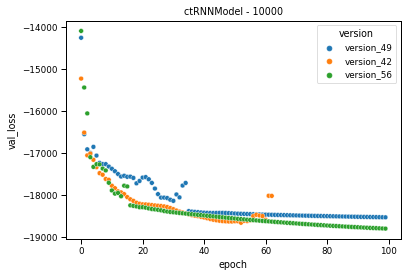

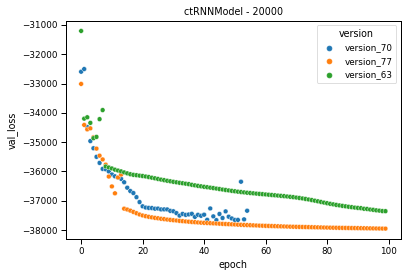

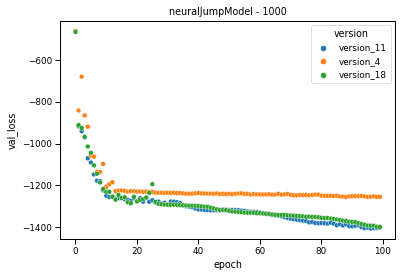

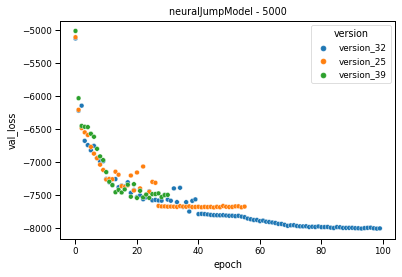

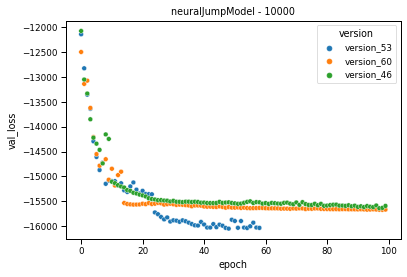

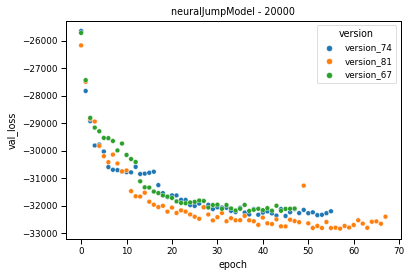

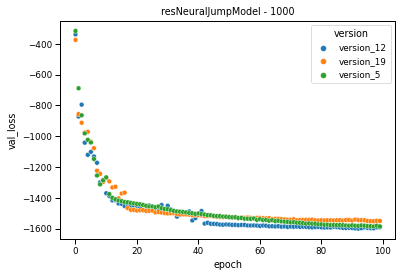

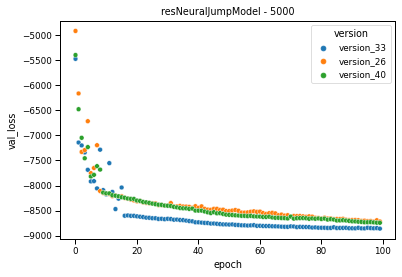

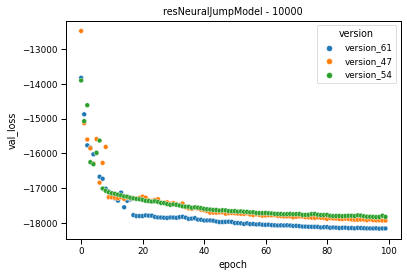

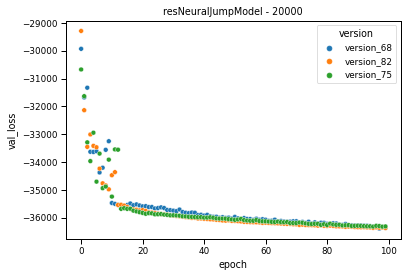

In [32]:
for i in range(model_N.shape[0]):
    df_plot = df_val.loc[(df_val.model == model_N.model[i]) & (df_val.N == model_N.N[i]),:]
    sns.scatterplot(x='epoch',y='val_loss',hue="version",data=df_plot)
    plt.title(model_N.model[i] + " - " + str(model_N.N[i]))
    plt.show()